In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import re
import csv
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from scipy.io import loadmat 
from pathlib import Path

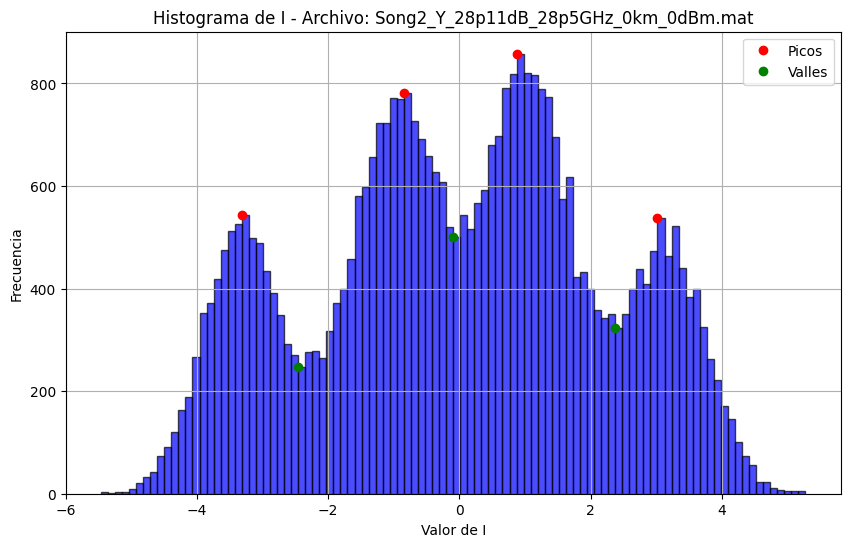

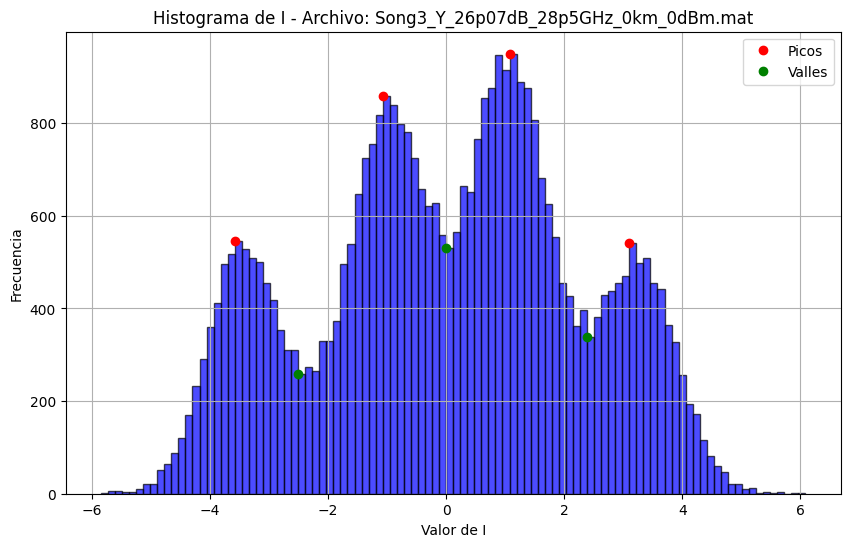

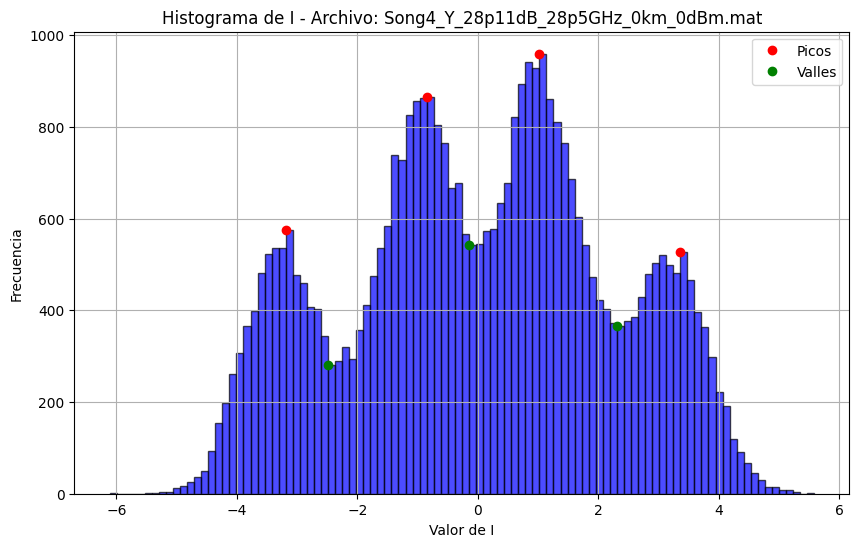

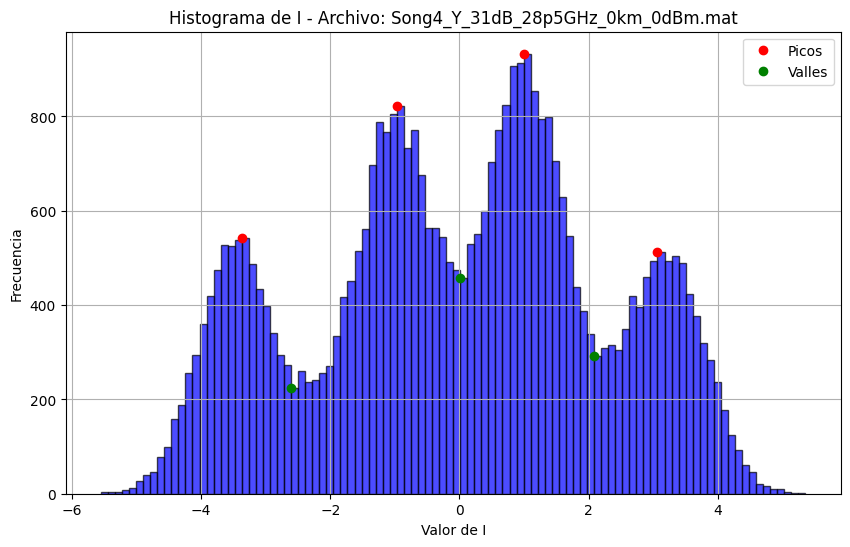

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Leer los datos de los archivos .mat en la carpeta específica
def read_csv_data(main_folder_path):
    data = {}

    # Ruta específica que queremos procesar
    specific_path = os.path.join(main_folder_path, "32GBd", "0km_0dBm", "28p5GHz")

    # Verifica si la ruta específica existe
    if os.path.exists(specific_path) and os.path.isdir(specific_path):
        key_path = "32GBd > 0km_0dBm > 28p5GHz"
        data[key_path] = []

        # Procesa solo los archivos en la carpeta especificada (Nivel 3)
        for filename in os.listdir(specific_path):
            # Solo procesa archivos con extensión .mat
            if filename.endswith(".mat"):
                file_path = os.path.join(specific_path, filename)

                # Lee el archivo .mat y convierte los datos a un DataFrame
                mat_data = loadmat(file_path)
                if "rconst" in mat_data:
                    df = mat_data["rconst"][0]
                    df = pd.DataFrame({"I": df.real, "Q": df.imag})

                    # Añade una tupla (nombre del archivo, DataFrame) a la lista
                    data[key_path].append((filename, df))
                else:
                    print(f"Advertencia: 'rconst' no encontrado en el archivo {filename}")
    else:
        print(f"La ruta específica '{specific_path}' no existe o no es válida.")
    
    return data

# Encontrar picos en un segmento
def find_peak_in_segment(counts, bin_edges, start, end):
    start_idx = np.searchsorted(bin_edges, start, side='left')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    if start_idx >= end_idx or start_idx >= len(counts):
        return None  # Segmento vacío o fuera de límites

    peak_idx = start_idx + np.argmax(counts[start_idx:end_idx])
    return peak_idx

# Encontrar valles en un segmento
def find_valley_in_segment(counts, bin_edges, start, end):
    start_idx = np.searchsorted(bin_edges, start, side='right')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    if start_idx >= end_idx or start_idx >= len(counts):
        return None  # Segmento vacío o fuera de límites

    valley_idx = start_idx + np.argmin(counts[start_idx:end_idx])
    return valley_idx

# Generar los histogramas para una subcarpeta específica
def plot_histograms_for_specific_subfolder(data, var_name):
    key_path = "32GBd > 0km_0dBm > 28p5GHz"
    results_all = {}

    # Verifica que la subcarpeta específica exista en los datos
    if key_path not in data:
        print(f"La subcarpeta '{key_path}' no existe en los datos.")
        return results_all

    files = data[key_path]

    # Procesa cada archivo en la subcarpeta específica
    for item in files:
        if len(item) != 2:
            print(f"Error: se esperaba una tupla con 2 elementos, pero se encontró: {item}")
            continue

        filename, df = item
        
        # Obtén los datos del histograma
        counts, bin_edges = np.histogram(df[var_name], bins=100)
        
        # Encontrar el pico más alto en cada segmento
        peaks = [
            find_peak_in_segment(counts, bin_edges, -4, -2),
            find_peak_in_segment(counts, bin_edges, -2, 0),
            find_peak_in_segment(counts, bin_edges, 0, 2),
            find_peak_in_segment(counts, bin_edges, 2, 4)
        ]
        
        # Encontrar el valle más bajo en cada segmento
        valleys = [
            find_valley_in_segment(counts, bin_edges, -3, -1),
            find_valley_in_segment(counts, bin_edges, -1, 1),
            find_valley_in_segment(counts, bin_edges, 1, 3)
        ]
        
        # Filtrar valores None
        peaks = [peak for peak in peaks if peak is not None]
        valleys = [valley for valley in valleys if valley is not None]
        
        # Guardar los resultados
        peaks_bin_edges = bin_edges[peaks]
        valleys_bin_edges = bin_edges[valleys]
        ensanchamiento = bin_edges[-1] - bin_edges[0]

        results_all[f'{key_path}_{filename}'] = {
            'peaks': peaks_bin_edges,
            'valleys': valleys_bin_edges,
            'ensanchamiento': ensanchamiento
        }
        
        # Graficar el histograma
        plt.figure(figsize=(10, 6))
        plt.hist(df[var_name], bins=100, alpha=0.7, color='blue', edgecolor='black')
        plt.plot(bin_edges[peaks], counts[peaks], 'ro', label='Picos')
        plt.plot(bin_edges[valleys], counts[valleys], 'go', label='Valles')
        plt.title(f'Histograma de {var_name} - Archivo: {filename}')
        plt.xlabel(f'Valor de {var_name}')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.grid(True)
        plt.show()

    return results_all

# Ruta principal y ejecución
main_folder_path = "/Users/USUARIO/Documents/ProyectoJames"
data = read_csv_data(main_folder_path)

if data:
    plot_histograms_for_specific_subfolder(data, var_name="I")


In [4]:
def read_csv_data(main_folder_path):
    data = {}

    # Ruta específica que queremos procesar
    specific_path = os.path.join(main_folder_path, "32GBd", "0km_0dBm", "28p5GHz")

    # Verifica si la ruta específica existe
    if os.path.exists(specific_path) and os.path.isdir(specific_path):
        data["32GBd"] = {"0km_0dBm": {"28p5GHz": []}}

        # Procesa solo los archivos en la carpeta especificada (Nivel 3)
        for filename in os.listdir(specific_path):
            # Solo procesa archivos con extensión .mat
            if filename.endswith(".mat"):
                file_path = os.path.join(specific_path, filename)

                # Lee el archivo mat, omitiendo la primera fila, sin encabezados, y separa los datos por comas
                mat_data = loadmat(file_path)
                df = mat_data["rconst"][0]
                df = pd.DataFrame({"I": df.real, "Q": df.imag})

                # Añade una tupla (nombre del archivo, DataFrame) a la lista
                data["32GBd"]["0km_0dBm"]["28p5GHz"].append((filename, df))

    else:
        print(f"La ruta específica '{specific_path}' no existe o no es válida.")
    
    return data

# Especifica la ruta a tu carpeta principal
main_folder_path = "Users/USUARIO/Documents/ProyectoJames"

# Llama a la función y almacena los datos en un diccionario
data = read_csv_data(main_folder_path)

# Opcional: imprimir la cantidad de archivos leídos en la carpeta específica
if "32GBd" in data:
    files = data["32GBd"]["0km_0dBm"]["28p5GHz"]
    print(f"Subcarpeta '32GBd > 0km_0dBm > 28p5GHz': se han leído {len(files)} archivos .mat.")



La ruta específica 'Users/USUARIO/Documents/ProyectoJames\32GBd\0km_0dBm\28p5GHz' no existe o no es válida.


In [32]:
# Listar subcarpetas en la ruta específica
def list_subfolders1(main_folder_path):
    # Ruta específica a procesar
    specific_path = os.path.join(main_folder_path, "32GBd", "0km_0dBm", "28p5GHz")
    dat = {}

    # Verifica si la ruta específica existe
    if os.path.exists(specific_path) and os.path.isdir(specific_path):
        print(f"Procesando subcarpeta: {specific_path}")
        # Lista los archivos en la ruta específica
        for subfolder in os.listdir(specific_path):
            subfolder_path = os.path.join(specific_path, subfolder)
            if os.path.isdir(subfolder_path):
                print(f"Subcarpeta encontrada: {subfolder}")  # Imprime el nombre de la subcarpeta
    else:
        print(f"La ruta '{specific_path}' no existe o no es válida.")
    
    return dat

# Encontrar picos en un segmento
def find_peak_in_segment(counts, bin_edges, start, end):
    # Encontrar los índices de los límites del segmento
    start_idx = np.searchsorted(bin_edges, start, side='left')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    # Verificar que el segmento no esté vacío o fuera de los límites
    if start_idx >= end_idx or start_idx >= len(counts):
        print(f"Segmento vacío o fuera de límites: start={start}, end={end}")
        return None  # Indica un error

    # Encontrar el índice del pico más alto en el segmento
    peak_idx = start_idx + np.argmax(counts[start_idx:end_idx])
    
    return peak_idx

# Encontrar valles en un segmento
def find_valley_in_segment(counts, bin_edges, start, end):
    # Encontrar los índices de los límites del segmento
    start_idx = np.searchsorted(bin_edges, start, side='right')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    # Verificar que el segmento no esté vacío o fuera de los límites
    if start_idx >= end_idx or start_idx >= len(counts):
        print(f"Segmento vacío o fuera de límites: start={start}, end={end}")
        return None  # Indica un error

    # Encontrar el índice del valle más bajo en el segmento
    valley_idx = start_idx + np.argmin(counts[start_idx:end_idx])
    
    return valley_idx

# Prueba del listado de subcarpetas
main_folder_path = "/Users/Camilo Anacona/Documents/Proyecto2James"
list_subfolders1(main_folder_path)


Procesando subcarpeta: /Users/Camilo Anacona/Documents/Proyecto2James\32GBd\0km_0dBm\28p5GHz


{}

In [33]:


def plot_histograms_for_specific_subfolder(data, var_name):
    # Ruta específica a procesar
    specific_path = "32GBd > 0km_0dBm > 28p5GHz"
    results_all = {}  # Inicializar el diccionario de resultados

    # Verifica que la subcarpeta específica exista en los datos
    if specific_path not in data:
        print(f"La subcarpeta '{specific_path}' no existe en los datos.")
        return results_all  # Retorna un diccionario vacío si no existe

    files = data[specific_path]

    # Procesa cada archivo en la subcarpeta específica
    for item in files:
        if len(item) != 2:
            print(f"Error: se esperaba una tupla con 2 elementos, pero se encontró: {item}")
            continue

        filename, df = item  # Asume que cada ítem es una tupla de (filename, DataFrame)
        
        # Obtén los datos del histograma
        counts, bin_edges = np.histogram(df[var_name], bins=100)
        
        # Encontrar el pico más alto en cada segmento
        peaks = [
            find_peak_in_segment(counts, bin_edges, -4, -2),
            find_peak_in_segment(counts, bin_edges, -2, 0),
            find_peak_in_segment(counts, bin_edges, 0, 2),
            find_peak_in_segment(counts, bin_edges, 2, 4)
        ]
        
        # Encontrar el valle más bajo en cada segmento
        valleys = [
            find_valley_in_segment(counts, bin_edges, -3, -1),
            find_valley_in_segment(counts, bin_edges, -1, 1),
            find_valley_in_segment(counts, bin_edges, 1, 3)
        ]
        
        # Filtrar los valores None si no se encontraron picos en algún segmento
        peaks = [peak for peak in peaks if peak is not None]
        valleys = [valley for valley in valleys if valley is not None]
        
        # Guardar los bin_edges de los picos y valles encontrados
        peaks_bin_edges = bin_edges[peaks]
        valleys_bin_edges = bin_edges[valleys]
        
        # Calcular el ensanchamiento
        min_value = min(bin_edges)
        max_value = max(bin_edges)
        ensanchamiento = max_value - min_value
        
        # Guardar los resultados
        results_all[f'{specific_path}_{filename}'] = {
            'peaks': peaks_bin_edges,
            'valleys': valleys_bin_edges,
            'ensanchamiento': ensanchamiento
        }
        
        # Generar la gráfica del histograma
        plt.figure(figsize=(10, 6))
        plt.hist(df[var_name], bins=100, alpha=0.7, color='blue', edgecolor='black')
        plt.plot(bin_edges[peaks], counts[peaks], 'ro', label='Picos')  # Resaltar los picos
        plt.plot(bin_edges[valleys], counts[valleys], 'go', label='Valles')  # Resaltar los valles
        plt.title(f'Histograma de {var_name} - Archivo: {filename}')
        plt.xlabel(f'Valor de {var_name}')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.grid(True)
        plt.show()

    return results_all


In [26]:
def plot_histograms_for_subfolder_all(data, subfolder_name, var_name):
    results_all = {}  # Inicializar siempre el diccionario de resultados
    if subfolder_name not in data:
        print(f"La subcarpeta '{subfolder_name}' no existe en los datos.")
        return results_all  # Retornar diccionario vacío si la subcarpeta no existe

    files = data[subfolder_name]

    # Verifica que los archivos sean una lista de tuplas con dos elementos
    for item in files:
        if len(item) != 2:
            print(f"Error: se esperaba una tupla con 2 elementos, pero se encontró: {item}")
            continue

        filename, df = item  # Asume que cada ítem es una tupla de (filename, DataFrame)
        
        # Obtén los datos del histograma
        counts, bin_edges = np.histogram(df[var_name], bins=100)
        
        # Encontrar el pico más alto en cada segmento
        peaks = [
            find_peak_in_segment(counts, bin_edges, -4, -2),
            find_peak_in_segment(counts, bin_edges, -2, 0),
            find_peak_in_segment(counts, bin_edges, 0, 2),
            find_peak_in_segment(counts, bin_edges, 2, 4)
        ]
        
        # Encontrar el valle más bajo en cada segmento
        valleys = [
            find_valley_in_segment(counts, bin_edges, -3, -1),
            find_valley_in_segment(counts, bin_edges, -1, 1),
            find_valley_in_segment(counts, bin_edges, 1, 3)
        ]
        
        # Filtrar los valores None si no se encontraron picos en algún segmento
        peaks = [peak for peak in peaks if peak is not None]
        valleys = [valley for valley in valleys if valley is not None]
        
        # Guardar los bin_edges de los picos y valles encontrados
        peaks_bin_edges = bin_edges[peaks]
        valleys_bin_edges = bin_edges[valleys]
        
        # Calcular el ensanchamiento
        min_value = min(bin_edges)
        max_value = max(bin_edges)
        ensanchamiento = max_value - min_value
        
        # Guardar los resultados
        results_all[f'{subfolder_name}_{filename}'] = {
            'peaks': peaks_bin_edges,
            'valleys': valleys_bin_edges,
            'ensanchamiento': ensanchamiento
        }
        
        # Generar la gráfica del histograma
        plt.figure(figsize=(10, 6))
        plt.hist(df[var_name], bins=100, alpha=0.7, color='blue', edgecolor='black')
        plt.plot(bin_edges[peaks], counts[peaks], 'ro')  # Resaltar los picos
        plt.plot(bin_edges[valleys], counts[valleys], 'go')  # Resaltar los valles
        plt.title(f'Histograma de {var_name} - Subcarpeta: {subfolder_name}, Archivo: {filename}')
        plt.xlabel(f'Valor de {var_name}')
        plt.ylabel('Frecuencia')
        plt.grid(True)
        plt.show()

    return results_all

In [22]:
print(data.items())

dict_items([('32GBd', {'0km_0dBm': {'28p5GHz': [('Song2_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -3.620020  3.221106
1      3.886321  1.629083
2      3.715104  3.970738
3     -0.802521 -4.227192
4      2.600286 -0.549269
...         ...       ...
39526  3.107871  0.808279
39527  1.051099 -1.484517
39528 -0.692446 -1.286135
39529  0.878934 -3.315101
39530  1.013196  1.001196

[39531 rows x 2 columns]), ('Song3_Y_26p07dB_28p5GHz_0km_0dBm.mat',               I         Q
0      0.844534 -1.244788
1      3.789840 -2.821729
2     -1.673740 -3.880104
3     -2.422620 -0.375730
4      0.312947  2.912408
...         ...       ...
39526 -1.759612  2.525436
39527 -0.610439  0.579856
39528  0.951177 -3.559550
39529  3.667480  4.443502
39530  3.812584  3.989728

[39531 rows x 2 columns]), ('Song4_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -0.725513  0.770507
1     -3.734069 -0.771531
2     -2.669921 -4.077023
3     -0.265249 -1.822847
4      0.134510  4.

In [37]:
def analyze_data(data):
    pattern = r'(\d+(\.\d+)?)GHz'
    pattern_osnr = r'(\d+(\.\d+)?)(?=dB)'

    matriz_caract = np.empty((0, 18))  # Inicializa la matriz vacía
    count = 0  # Contador para limitar a 3 histogramas

    for subfolder1, subfolders2 in data.items():
        
       
        for subfolder2, subfolders3 in subfolders2.items():
            print(subfolder2)
            if 'dBm' in subfolder2:  # Verificar que el nombre de la subcarpeta contenga 'dBm'
                print(f'se está leyendo: {subfolder2}')
                for subfolder3, files in subfolders3.items(): # <-
                    print(f'Carpeta en Nivel 3: {subfolder3}, Archivos: {files}')
 
                    if 'GHz' in subfolder3:  # Verificar que el nombre de la subcarpeta contenga 'GHz'
                        print(f'se está leyendo: {subfolder3} con GHz')
                        for filename, df in files:
                            match = re.search(pattern, subfolder3)  # Busca en el nombre de la subcarpeta
                            #print(f'hay match')
                            spacing = float(match.group(1)) if match else None

                            # Aquí usamos subfolder3 en lugar de filename
                            resultsI = plot_histograms_for_subfolder_all(data[subfolder1][subfolder2], subfolder3, 'I')
                            #print(f"MUERTEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE :3")
                            resultsQ = plot_histograms_for_subfolder_all(data[subfolder1][subfolder2], subfolder3, 'Q')

                            for resultI, resultQ in zip(resultsI.items(), resultsQ.items()):
                                #if count >= 3:  # Limitar a 3 histogramas
                                 #   print("Se han generado 3 histogramas. Finalizando...")
                                  #  return matriz_caract

                                match = re.search(pattern_osnr, resultI[0])
                                OSNR = float(match.group(1)) if match else None

                                I = resultI[1]
                                Q = resultQ[1]

                                vector = np.hstack((
                                    I["peaks"], Q["peaks"],
                                    I["valleys"], Q["valleys"],
                                    I["ensanchamiento"],
                                    Q["ensanchamiento"],
                                    [spacing, OSNR]
                                ))

                                matriz_caract = np.vstack((matriz_caract, vector))
                                count += 1  # Incrementa el contador
                    else:
                        print("No se encontró la subcarpeta 'GHz'.")



    return matriz_caract

# Especifica la ruta a tu carpeta principal
#main_folder_path = 'Song1_Y_23p05dB_30GHz_270km_0dBm.mat'

# Llama a la función y almacena los datos en un diccionario
#data = read_csv_data(main_folder_path)

# Análisis de datos
matriz_caract = analyze_data(data)

# Aquí puedes realizar más análisis o guardar 'matriz_caract' según lo que necesites

270km_0dBm
se está leyendo: 270km_0dBm
Carpeta en Nivel 3: 30GHz, Archivos: [('Song4_Y_24p93dB_30GHz_270km_0dBm.mat',               I         Q
0      1.310095  3.017568
1      4.268198  0.087642
2      0.104091 -1.738077
3      2.821031  0.348048
4     -0.673230  1.696100
...         ...       ...
39526 -1.915510 -3.167299
39527  3.796958  4.453150
39528  3.369277  3.164143
39529  1.319127 -0.304751
39530 -0.593273  0.051388

[39531 rows x 2 columns]), ('Song1_Y_23p05dB_30GHz_270km_0dBm.mat',               I         Q
0      0.277643 -2.544757
1     -2.767118 -4.284170
2     -3.454462 -1.114674
3     -0.110853  0.277507
4      3.043603 -3.999439
...         ...       ...
39526 -1.111249  1.628992
39527  1.111319  0.795971
39528  1.998631  1.718751
39529  0.837759 -1.798924
39530  4.201500 -4.032074

[39531 rows x 2 columns]), ('Song3_X_25p9dB_30GHz_270km_0dBm.mat',               I         Q
0      2.723133 -1.321994
1     -2.214644 -2.600971
2     -2.332470 -3.101774
3      3.605093 -

Carpeta en Nivel 3: 36GHz, Archivos: [('Song2_Y_24p06dB_36GHz_270km_0dBm.mat',               I         Q
0      3.200038  2.427062
1      2.950168  3.140232
2      2.812331 -3.131212
3     -0.563332  1.311127
4      3.141983 -3.339729
...         ...       ...
39526  2.472724 -0.488929
39527 -2.654552  3.193913
39528 -0.783665 -1.174359
39529  1.053513 -2.810591
39530 -2.897344  2.858699

[39531 rows x 2 columns]), ('Song1_Y_21p96dB_36GHz_270km_0dBm.mat',               I         Q
0     -2.591438  3.376521
1     -2.192708  3.789244
2      3.669869  1.040717
3     -1.140328 -2.499357
4      3.617481  2.228424
...         ...       ...
39526  0.862587  0.615540
39527 -0.925750  1.457237
39528 -0.634395 -2.746916
39529 -3.018347 -0.632669
39530 -0.817913 -1.063707

[39531 rows x 2 columns]), ('Song1_Y_16p02dB_36GHz_270km_0dBm.mat',               I         Q
0     -1.955422 -0.414257
1     -3.033704 -3.432799
2      3.355695 -2.223282
3      0.099945 -3.221510
4     -2.168975 -0.199316
...

Carpeta en Nivel 3: 33p5GHz, Archivos: [('Song3_X_25p04dB_33p5GHz_270km_0dBm.mat',               I         Q
0     -2.448437  1.609796
1      1.824291 -3.539815
2      3.035406  0.970847
3     -3.734777  2.849953
4      1.374062 -2.644111
...         ...       ...
39526 -1.214737 -1.075944
39527 -3.363890 -1.239710
39528  0.581677  0.709837
39529  1.423426  2.994077
39530 -3.564058  0.581544

[39531 rows x 2 columns]), ('Song1_X_22p14dB_33p5GHz_270km_0dBm.mat',               I         Q
0     -3.551949  2.626596
1      2.855673  1.252915
2      1.228454 -3.299947
3     -2.840273  1.428820
4      1.492343  1.429656
...         ...       ...
39526  2.462705 -2.835065
39527  1.564381 -3.249639
39528 -2.535471 -1.581676
39529  2.865594  0.794402
39530  1.803904 -0.930871

[39531 rows x 2 columns]), ('Song4_Y_23p14dB_33p5GHz_270km_0dBm.mat',               I         Q
0      0.437408  0.357706
1     -2.865054 -3.227615
2      3.043889 -1.212880
3      2.945179 -1.555233
4     -0.911729  2.98

Carpeta en Nivel 3: 29p5GHz, Archivos: [('Song4_Y_25p03dB_29p5GHz_270km_0dBm.mat',               I         Q
0     -2.979757  1.575339
1      3.987418  0.991262
2      1.212543  0.499666
3     -3.813300  1.592985
4      2.423213  4.472332
...         ...       ...
39526 -1.124454  3.359009
39527 -2.717188  2.173808
39528  2.026211 -0.836217
39529  0.972930  1.328599
39530  0.148172 -2.410464

[39531 rows x 2 columns])]
se está leyendo: 29p5GHz con GHz
Carpeta en Nivel 3: 32p5GHz, Archivos: [('Song3_Y_24p08dB_32p5GHz_270km_0dBm.mat',               I         Q
0      0.603993 -0.602244
1      2.523996  2.473185
2      1.058993 -2.994753
3      0.236004 -2.285563
4     -2.665997  0.923412
...         ...       ...
39526  0.789192 -1.095650
39527 -0.908907  3.017941
39528 -3.595941 -0.706822
39529 -2.584374 -3.189879
39530 -0.734011  2.734841

[39531 rows x 2 columns]), ('Song2_X_24p08dB_32p5GHz_270km_0dBm.mat',               I         Q
0      4.249479 -1.551377
1     -1.071852  0.902298


Carpeta en Nivel 3: 34GHz, Archivos: [('Song1_X_24p13dB_34GHz_270km_0dBm.mat',               I         Q
0     -0.564087 -1.667256
1     -2.188816  2.217649
2     -0.434493 -0.938612
3     -1.076246  1.574544
4      3.296045 -0.358597
...         ...       ...
39526 -2.678529  1.759166
39527 -0.901278 -3.582369
39528  1.413082  3.118422
39529 -3.042036  2.520621
39530 -3.278271 -1.208937

[39531 rows x 2 columns]), ('Song3_X_20p05dB_34GHz_270km_0dBm.mat',               I         Q
0      1.404140  0.898619
1      0.662739 -0.157748
2     -2.980548  1.506352
3     -0.791555  2.630074
4     -0.819815  0.992999
...         ...       ...
39526  2.956811  1.284410
39527  2.350225  3.443552
39528  0.861760  1.463041
39529 -0.772316  2.379748
39530  0.442502 -0.050948

[39531 rows x 2 columns]), ('Song4_X_22p02dB_34GHz_270km_0dBm.mat',               I         Q
0     -3.323609 -3.054455
1      3.050262 -3.343342
2      2.596473 -1.712259
3     -1.137668  1.098970
4      2.849152 -3.433491
...

Carpeta en Nivel 3: 32GHz, Archivos: [('Song1_X_19dB_32GHz_270km_0dBm.mat',               I         Q
0     -2.697786 -2.449894
1     -2.930621 -1.132165
2     -1.634182  0.360146
3      3.446693 -2.254182
4     -2.716137 -1.268273
...         ...       ...
39526 -0.860592 -0.937694
39527 -3.598941 -3.240585
39528 -2.559064  3.135937
39529  0.383365  0.740386
39530  0.494508 -3.148739

[39531 rows x 2 columns]), ('Song3_X_22p09dB_32GHz_270km_0dBm.mat',               I         Q
0      1.214855 -0.014211
1     -0.991788 -0.097786
2      3.095785  1.802476
3      2.386554  2.316328
4      1.707759  3.096127
...         ...       ...
39526  2.441746  0.397700
39527 -1.008401  1.207311
39528  0.153213  0.549211
39529 -2.420392  1.156013
39530 -1.370261  2.344682

[39531 rows x 2 columns]), ('Song1_Y_19p98dB_32GHz_270km_0dBm.mat',               I         Q
0      1.613250 -2.748893
1     -0.703088 -1.688958
2     -0.140142 -3.687684
3     -1.448324  0.263683
4     -1.254346  1.352023
...   

Carpeta en Nivel 3: 37p5GHz, Archivos: [('Song2_X_16p08dB_37p5GHz_270km_0dBm.mat',               I         Q
0      3.668241 -0.540525
1      2.365637  0.565095
2     -0.259305  1.258346
3      3.419897  2.389700
4     -2.386861  0.613998
...         ...       ...
39526 -1.558060 -1.609221
39527 -3.642654  0.709858
39528 -2.617576 -1.215180
39529 -2.873014 -1.235676
39530  0.403672 -2.705043

[39531 rows x 2 columns]), ('Song4_Y_18p96dB_37p5GHz_270km_0dBm.mat',               I         Q
0      1.390391 -0.043856
1      2.418337  3.278640
2     -1.675667  3.559917
3     -0.379451  3.495585
4      0.784346 -2.603209
...         ...       ...
39526  0.686043  2.769933
39527 -2.499690  2.648297
39528  1.591690 -2.640280
39529  0.649188  2.951941
39530 -0.588484 -1.053578

[39531 rows x 2 columns]), ('Song1_Y_22p09dB_37p5GHz_270km_0dBm.mat',               I         Q
0     -2.972839  3.053565
1      0.851344  2.649676
2      1.495460 -2.578456
3     -3.053912  3.295192
4     -1.827789 -1.03

Carpeta en Nivel 3: 30p5GHz, Archivos: [('Song2_Y_24p1dB_30p5GHz_270km_0dBm.mat',               I         Q
0     -3.624223  2.771847
1     -0.389926  2.979351
2      0.359923 -2.497618
3     -2.049319  2.801088
4     -1.607555 -3.653940
...         ...       ...
39526 -0.367333 -4.104099
39527  2.008170 -3.370568
39528 -0.411773 -0.175613
39529 -1.098438  0.916482
39530  0.956512 -2.845055

[39531 rows x 2 columns]), ('Song4_Y_18p95dB_30p5GHz_270km_0dBm.mat',               I         Q
0     -3.164161 -2.855416
1     -2.863486  2.481425
2     -2.589405 -1.222063
3      3.765679  3.791387
4     -0.292949 -1.231350
...         ...       ...
39526 -1.192511 -1.699406
39527 -1.510299 -1.532557
39528 -1.979117  0.500940
39529 -0.043333 -2.956579
39530  2.459230 -0.702811

[39531 rows x 2 columns]), ('Song1_Y_23p19dB_30p5GHz_270km_0dBm.mat',               I         Q
0      0.789072 -1.884585
1     -2.585977 -2.625651
2     -0.745517 -2.436729
3     -1.233363 -0.852370
4      0.732738  2.083

Carpeta en Nivel 3: 33GHz, Archivos: [('Song4_X_21p08dB_33GHz_270km_0dBm.mat',               I         Q
0      1.089266 -1.639876
1      2.528355  0.951870
2      1.138555 -2.551590
3      4.413965 -3.474022
4     -3.405585 -2.447945
...         ...       ...
39526  0.849859 -2.429678
39527 -3.058062  3.014536
39528 -2.979733 -1.066943
39529 -0.951187  0.028488
39530  0.789739 -2.838177

[39531 rows x 2 columns]), ('Song4_Y_24p93dB_33GHz_270km_0dBm.mat',               I         Q
0      0.908498  0.098872
1     -1.201119 -3.573316
2     -1.148695  1.375627
3     -1.164179  0.350641
4     -3.272872 -2.744619
...         ...       ...
39526 -2.541212 -3.731773
39527 -2.270132 -0.896712
39528  0.613460 -2.789730
39529 -0.222351  0.666975
39530  0.679322  2.961877

[39531 rows x 2 columns]), ('Song1_X_22p98dB_33GHz_270km_0dBm.mat',               I         Q
0     -2.832439 -3.141234
1      2.519954 -1.091413
2     -1.243985 -3.382734
3      2.847677  3.355146
4     -0.469560  2.324215
...

Carpeta en Nivel 3: 31p5GHz, Archivos: [('Song1_Y_25p02dB_31p5GHz_270km_0dBm.mat',               I         Q
0      2.722189  2.186327
1      1.461610 -2.655178
2      0.920543  2.810807
3     -0.696370 -0.686126
4     -3.433987  2.767890
...         ...       ...
39526  3.573885  0.669091
39527 -2.494426  1.148599
39528 -1.981659  2.843967
39529 -0.280217  0.782095
39530  1.984797  0.825969

[39531 rows x 2 columns]), ('Song2_Y_23p12dB_31p5GHz_270km_0dBm.mat',               I         Q
0     -0.932320  2.456392
1      1.664677  3.755680
2      2.293423  2.779009
3      3.573729 -0.548973
4      3.335488  0.412839
...         ...       ...
39526 -0.916504  0.635416
39527 -3.220707  1.304763
39528  1.964133  1.284375
39529 -0.156121  2.729820
39530 -2.743762  1.114095

[39531 rows x 2 columns]), ('Song2_X_26p26dB_31p5GHz_270km_0dBm.mat',               I         Q
0     -3.897863  2.582784
1     -2.902523  2.403830
2     -1.272788 -1.519697
3      0.597734  0.790865
4     -1.594901 -0.87

Carpeta en Nivel 3: 31GHz, Archivos: [('Song1_X_22p09dB_31GHz_270km_0dBm.mat',               I         Q
0      2.915538  1.097664
1      1.291740  0.749300
2     -0.933252 -0.781958
3      0.614239 -0.810103
4      0.863899 -1.218639
...         ...       ...
39526  3.339108  3.150538
39527  0.643941  3.425436
39528 -3.572157  0.527298
39529  3.584281 -0.848744
39530  0.033551  1.214365

[39531 rows x 2 columns]), ('Song3_X_23p18dB_31GHz_270km_0dBm.mat',               I         Q
0     -0.924827 -1.073063
1     -1.182785 -2.792745
2      1.423282  0.922515
3      3.135240  2.546672
4      3.097827 -0.768476
...         ...       ...
39526  0.875602  0.723969
39527 -2.810877 -0.748622
39528 -2.957452 -1.024846
39529 -1.449259 -0.558136
39530  0.662461 -3.483230

[39531 rows x 2 columns]), ('Song4_Y_25p1dB_31GHz_270km_0dBm.mat',               I         Q
0      0.635581  1.169550
1     -0.083677 -3.179158
2      3.174166 -0.695952
3      2.618287 -0.638972
4      0.471432  3.161306
... 

Carpeta en Nivel 3: 50GHz, Archivos: [('Song4_Y_18p95dB_50GHz_270km_0dBm.mat',               I         Q
0      0.321444 -2.453466
1      2.511513 -0.954791
2     -1.102778  3.257173
3     -2.897834 -1.116034
4      1.123853 -1.770639
...         ...       ...
39526 -1.039733 -2.746443
39527  2.559081  1.029665
39528 -0.876985 -0.624784
39529 -3.393902  0.443851
39530  0.850137  3.137205

[39531 rows x 2 columns]), ('Song1_Y_15p07dB_50GHz_270km_0dBm.mat',               I         Q
0     -0.611975 -0.114685
1     -2.046738 -4.211643
2     -1.690867 -3.516437
3     -1.000936 -1.875265
4      0.264408  0.661174
...         ...       ...
39526 -0.596876 -0.393404
39527 -3.479166  2.203411
39528 -0.983071 -1.819764
39529 -1.623710 -3.869708
39530  2.233437  0.934231

[39531 rows x 2 columns]), ('Song1_Y_23p25dB_50GHz_270km_0dBm.mat',               I         Q
0      3.068542 -2.383389
1      0.841997  0.465907
2     -1.187204 -2.964306
3      1.053200  1.841711
4      2.935045  0.818868
...

Carpeta en Nivel 3: 35p5GHz, Archivos: [('Song1_X_24p07dB_35p5GHz_270km_0dBm.mat',               I         Q
0      2.726736  0.181819
1     -2.492928 -3.327416
2      0.285962 -2.489577
3     -3.413915 -0.730788
4      3.211817  1.073142
...         ...       ...
39526 -0.740423 -3.149653
39527  1.408180 -2.116269
39528 -2.626187  2.594181
39529 -3.192570 -3.160623
39530 -0.616798  1.198131

[39531 rows x 2 columns]), ('Song3_X_25p68dB_35p5GHz_270km_0dBm.mat',               I         Q
0      2.241496  2.695989
1      2.559438  1.008337
2      1.332571  1.234498
3     -1.571220 -3.616747
4      0.962406 -1.390293
...         ...       ...
39526  1.198022 -2.640388
39527  2.882758 -3.187522
39528  0.374642 -1.087156
39529  3.145145  2.325508
39530 -1.785792 -1.057842

[39531 rows x 2 columns]), ('Song1_Y_25p68dB_35p5GHz_270km_0dBm.mat',               I         Q
0      3.836016  2.502169
1     -0.575109  0.828109
2      1.130937  3.579712
3     -3.324891 -1.391558
4     -0.414211 -1.22

0km_0dBm
se está leyendo: 0km_0dBm
Carpeta en Nivel 3: 30GHz, Archivos: [('Song4_X_23p07dB_30GHz_0km_0dBm.mat',               I         Q
0     -0.693847  2.242173
1      1.240218 -0.151294
2     -2.647807 -2.425960
3     -1.502663  3.468298
4     -1.411509  4.449857
...         ...       ...
39526 -0.884370  4.322045
39527 -3.478514 -3.407889
39528 -0.082606 -3.204173
39529  3.197789  0.692414
39530 -2.751998 -4.108503

[39531 rows x 2 columns]), ('Song3_Y_29p05dB_30GHz_0km_0dBm.mat',               I         Q
0      1.133376  1.510335
1      3.122398  2.797508
2     -2.613884  2.875439
3     -2.400484  2.445819
4      2.575475 -0.053202
...         ...       ...
39526  0.027183 -0.387725
39527  2.447717 -1.652263
39528 -1.267682  1.536780
39529 -1.846850  1.214434
39530  4.230905  3.173145

[39531 rows x 2 columns]), ('Song3_Y_23p07dB_30GHz_0km_0dBm.mat',               I         Q
0      2.521374  3.614825
1     -0.009581  3.921313
2     -3.926488  2.742717
3      3.163638 -2.487709


Carpeta en Nivel 3: 29GHz, Archivos: [('Song3_Y_29p94dB_29GHz_0km_0dBm.mat',               I         Q
0     -2.589898 -0.781617
1     -3.890634  1.470680
2      0.499675 -1.522790
3      3.589403 -3.649264
4     -1.564832 -1.914713
...         ...       ...
39526 -1.022283 -3.841141
39527  1.376442 -1.698760
39528  2.061079  1.555632
39529  4.510710 -4.519192
39530  3.043301  2.218082

[39531 rows x 2 columns]), ('Song3_Y_20p04dB_29GHz_0km_0dBm.mat',               I         Q
0     -0.989738  1.292576
1     -1.460878 -1.151786
2     -4.331977  1.471734
3     -1.635322  4.404330
4      0.401342  0.240222
...         ...       ...
39526  1.024454 -1.520653
39527  2.398171 -1.268381
39528  3.841601 -1.704311
39529  1.724789 -1.399225
39530  0.235383 -2.550178

[39531 rows x 2 columns]), ('Song2_X_48p6dB_29GHz_0km_0dBm.mat',               I         Q
0      3.062705 -0.765755
1     -0.307810 -0.822765
2      1.028314 -0.284281
3     -0.534982 -1.504280
4      2.237400 -2.403540
...       

Carpeta en Nivel 3: 36GHz, Archivos: [('Song2_Y_20p97dB_36GHz_0km_0dBm.mat',               I         Q
0      1.422672  1.127959
1      2.980706  3.226097
2      1.402221  0.990059
3      0.702321  3.460947
4     -2.720849 -1.778659
...         ...       ...
39526  2.738786  0.990763
39527 -3.223719 -1.021248
39528 -2.015682 -3.284570
39529  0.496541 -1.477719
39530 -2.875838 -0.609434

[39531 rows x 2 columns]), ('Song3_Y_27p02dB_36GHz_0km_0dBm.mat',               I         Q
0     -2.452961  2.489466
1      2.619645  2.869611
2      2.818942 -3.846530
3     -2.936399  3.490470
4      1.254165 -0.906904
...         ...       ...
39526 -3.014637  0.873469
39527  0.965751 -1.225917
39528  1.319458 -0.814834
39529 -2.724937 -1.217223
39530 -3.540036 -2.533042

[39531 rows x 2 columns]), ('Song1_Y_28p01dB_36GHz_0km_0dBm.mat',               I         Q
0     -0.921103  0.939811
1     -1.046282 -3.348004
2     -2.763529 -3.046350
3     -1.155238 -0.946015
4     -0.819547  1.277654
...      

Carpeta en Nivel 3: 33p5GHz, Archivos: [('Song2_X_26p05dB_33p5GHz_0km_0dBm.mat',               I         Q
0      2.268376  0.946576
1     -2.851615 -0.848845
2      0.985864  3.226999
3     -0.722338  3.174406
4      2.655935  3.010268
...         ...       ...
39526  3.472134 -2.823202
39527  1.574920  0.896614
39528 -2.627619  1.115570
39529  0.780412 -1.573727
39530  0.829182 -0.434289

[39531 rows x 2 columns]), ('Song1_X_23p03dB_33p5GHz_0km_0dBm.mat',               I         Q
0     -0.728775 -1.495663
1      3.426351 -0.808126
2     -2.830108 -2.799062
3     -0.896229 -0.909712
4      2.676292 -3.488534
...         ...       ...
39526 -1.697391  3.264449
39527  3.484866 -0.162731
39528 -1.349808 -2.028934
39529  1.283158  3.532064
39530 -3.474342  1.091525

[39531 rows x 2 columns]), ('Song1_Y_16dB_33p5GHz_0km_0dBm.mat',               I         Q
0      0.663450 -3.135351
1      3.400529  1.108902
2      1.536754 -2.548989
3      2.099903  0.454885
4     -3.627073  3.336630
... 

Carpeta en Nivel 3: 29p5GHz, Archivos: [('Song3_Y_21p14dB_29p5GHz_0km_0dBm.mat',               I         Q
0     -0.431753 -3.963180
1      2.921286  1.061745
2     -1.255604  0.605171
3     -1.418655 -1.431015
4      4.462567 -4.021020
...         ...       ...
39526 -1.557967 -2.554040
39527  0.586271  0.335490
39528  0.620201 -2.856670
39529  0.941565  3.532560
39530  3.469537  0.860458

[39531 rows x 2 columns]), ('Song4_X_27p06dB_29p5GHz_0km_0dBm.mat',               I         Q
0      0.922064  0.972822
1     -1.352299  1.857201
2      1.672782  3.581597
3      3.758387 -1.654232
4      3.248476 -1.670569
...         ...       ...
39526  0.343409  3.309443
39527 -0.269446  0.731240
39528  1.746041 -1.116212
39529  0.647259  0.786545
39530 -0.078960  2.438389

[39531 rows x 2 columns]), ('Song1_X_30dB_29p5GHz_0km_0dBm.mat',               I         Q
0     -0.422046  4.179131
1      0.330643 -1.689204
2      0.299326 -0.854851
3      0.835704  2.254891
4     -0.401448  2.376027
... 

Carpeta en Nivel 3: 32p5GHz, Archivos: [('Song1_X_25p09dB_32p5GHz_0km_0dBm.mat',               I         Q
0      0.521169 -1.318851
1      2.518169 -1.054398
2     -2.422243  1.103416
3     -1.630746  2.857916
4      1.040935  0.927987
...         ...       ...
39526 -3.214347 -0.908768
39527 -1.264836 -1.339632
39528  1.178492  2.893031
39529 -2.129917  3.601586
39530 -2.806488  2.853425

[39531 rows x 2 columns]), ('Song1_Y_23p02dB_32p5GHz_0km_0dBm.mat',               I         Q
0      1.096366 -2.964668
1      1.168101  2.461350
2     -0.640497  1.234504
3     -1.416149 -1.443906
4     -1.865738  1.373473
...         ...       ...
39526  3.000476 -0.549941
39527 -2.368439  2.901285
39528  0.443106 -1.851626
39529 -3.159093 -0.068472
39530  1.074330  3.359645

[39531 rows x 2 columns]), ('Song2_Y_18p99dB_32p5GHz_0km_0dBm.mat',               I         Q
0      0.810984  4.657676
1      2.629087  0.773495
2     -3.151253  1.551971
3     -2.280474 -1.185180
4      0.458101 -1.310625
.

Carpeta en Nivel 3: 34GHz, Archivos: [('Song1_X_22p97dB_34GHz_0km_0dBm.mat',               I         Q
0      3.299516 -3.519314
1     -0.914270 -1.191399
2     -0.789210 -3.338915
3      3.422287  0.851581
4      0.748556  2.570854
...         ...       ...
39526  2.428947  1.160450
39527  2.902378  0.557138
39528 -0.900791  3.152598
39529  0.882067  1.396725
39530 -0.319065  0.877353

[39531 rows x 2 columns]), ('Song2_Y_29p98dB_34GHz_0km_0dBm.mat',               I         Q
0      2.949099  1.624325
1      2.980120  2.802915
2      3.838381 -1.969296
3     -3.170162 -3.652429
4      3.183680  1.647378
...         ...       ...
39526  3.019417  0.444614
39527  3.190809  1.171096
39528 -1.237424 -1.390103
39529  1.396584 -2.900927
39530 -1.299634 -1.043991

[39531 rows x 2 columns]), ('Song1_Y_24p02dB_34GHz_0km_0dBm.mat',               I         Q
0      1.103019 -0.987793
1     -3.364752 -0.350137
2      0.640170  2.871644
3      3.339689  0.096479
4     -1.294138  3.041246
...      

Carpeta en Nivel 3: 32GHz, Archivos: [('Song3_Y_24p03dB_32GHz_0km_0dBm.mat',               I         Q
0      2.596723  1.151216
1      1.289532  2.917008
2     -3.289003 -0.632726
3      1.371350 -2.950834
4      0.911241  1.322195
...         ...       ...
39526  2.042581 -0.434924
39527  3.183046 -1.399513
39528 -3.068881  0.652064
39529  0.430420  3.430901
39530 -0.589776  1.451709

[39531 rows x 2 columns]), ('Song3_Y_29p03dB_32GHz_0km_0dBm.mat',               I         Q
0     -1.295795 -1.311851
1      3.116001  0.959409
2     -3.492085  0.959305
3     -1.870035  2.125568
4      0.391498  2.191127
...         ...       ...
39526  3.748569  1.662574
39527  0.329428  2.393115
39528 -2.820641 -2.484169
39529  1.317024 -2.857181
39530  2.941438  2.862251

[39531 rows x 2 columns]), ('Song4_Y_29p03dB_32GHz_0km_0dBm.mat',               I         Q
0      1.565503  3.789459
1     -2.757540 -2.463529
2      0.562125 -3.881103
3      1.532400  3.348024
4     -3.191993 -1.040131
...      

Carpeta en Nivel 3: 37p5GHz, Archivos: [('Song1_Y_23p04dB_37p5GHz_0km_0dBm.mat',               I         Q
0      2.844127  1.686555
1      3.197461  2.766943
2     -0.844140  0.956977
3      0.445483  0.540632
4     -0.690185 -1.559262
...         ...       ...
39526 -0.585471  0.258579
39527 -2.497948  0.960884
39528  3.110522 -1.140164
39529  1.472326 -3.444626
39530 -3.593224 -1.624903

[39531 rows x 2 columns]), ('Song2_X_24p08dB_37p5GHz_0km_0dBm.mat',               I         Q
0     -1.374781 -0.571341
1     -2.418581  0.867682
2     -1.605425 -2.308739
3     -0.828739 -1.415051
4      2.415893 -3.255039
...         ...       ...
39526  3.396986  2.673715
39527  2.882946 -2.458337
39528 -4.320206 -3.299727
39529  2.912851  2.798767
39530 -2.426137 -2.870261

[39531 rows x 2 columns]), ('Song4_Y_22p02dB_37p5GHz_0km_0dBm.mat',               I         Q
0     -1.097548  0.308265
1      3.184080  3.503965
2      3.123374 -2.888144
3      2.704171 -1.282084
4     -2.948573  3.000688
.

Carpeta en Nivel 3: 30p5GHz, Archivos: [('Song4_Y_29p08dB_30p5GHz_0km_0dBm.mat',               I         Q
0     -3.588456 -2.419489
1     -0.978401 -3.085895
2     -0.942016 -0.331181
3      0.609801  2.656084
4      1.484547 -1.043456
...         ...       ...
39526  0.826476  1.412007
39527 -0.750196 -1.117830
39528 -1.813860 -0.557912
39529 -2.689047 -2.817512
39530 -2.806127 -2.668681

[39531 rows x 2 columns]), ('Song3_X_24p96dB_30p5GHz_0km_0dBm.mat',               I         Q
0     -3.323043  2.474386
1     -2.384728  1.443198
2      0.000513 -3.378831
3     -3.157044  1.514179
4      1.091911  2.742220
...         ...       ...
39526 -2.909054 -0.503085
39527 -2.839169  0.444061
39528  0.598788 -0.861786
39529 -3.167311 -3.440517
39530  1.870049 -1.700377

[39531 rows x 2 columns]), ('Song1_X_22p05dB_30p5GHz_0km_0dBm.mat',               I         Q
0      0.690925  1.225678
1      0.881198 -2.986484
2     -2.532497 -2.772710
3     -1.751238 -0.838458
4     -0.913460  0.832375
.

Carpeta en Nivel 3: 34p5GHz, Archivos: [('Song3_Y_18p17dB_34p5GHz_0km_0dBm.mat',               I         Q
0      2.050314 -1.972682
1     -0.780303 -0.153525
2      0.637587  0.076953
3     -1.318701  2.892740
4     -1.080886  3.381213
...         ...       ...
39526  2.888790  2.785631
39527 -3.081428  0.340491
39528 -2.338211  3.325070
39529  0.531912 -2.945079
39530 -3.151892 -2.967143

[39531 rows x 2 columns]), ('Song3_Y_29p07dB_34p5GHz_0km_0dBm.mat',               I         Q
0     -1.492739 -2.765657
1     -2.978255 -3.146075
2      0.850294 -2.890281
3      2.688832  2.847475
4     -1.093957 -2.630390
...         ...       ...
39526 -2.962000 -2.950608
39527 -1.197306  0.904636
39528 -3.172993  2.482837
39529  2.838906 -2.903099
39530  1.298880 -2.112297

[39531 rows x 2 columns]), ('Song1_Y_23p02dB_34p5GHz_0km_0dBm.mat',               I         Q
0     -3.246854 -2.255287
1     -0.939090  2.199319
2      3.426952 -2.468724
3     -3.303351  2.497311
4     -2.023997  2.860745
.

Carpeta en Nivel 3: 28p5GHz, Archivos: [('Song2_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -3.620020  3.221106
1      3.886321  1.629083
2      3.715104  3.970738
3     -0.802521 -4.227192
4      2.600286 -0.549269
...         ...       ...
39526  3.107871  0.808279
39527  1.051099 -1.484517
39528 -0.692446 -1.286135
39529  0.878934 -3.315101
39530  1.013196  1.001196

[39531 rows x 2 columns]), ('Song4_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -0.725513  0.770507
1     -3.734069 -0.771531
2     -2.669921 -4.077023
3     -0.265249 -1.822847
4      0.134510  4.937364
...         ...       ...
39526 -0.153190  1.415550
39527  0.462021 -3.785083
39528 -3.004357  1.253444
39529  2.706599  4.178695
39530  2.802634 -2.747253

[39531 rows x 2 columns]), ('Song4_Y_31dB_28p5GHz_0km_0dBm.mat',               I         Q
0      1.027043  3.490767
1      2.239234  1.573672
2      0.733466 -3.858586
3     -0.608503  3.189502
4      0.242891  4.274843
... 

Carpeta en Nivel 3: 31p5GHz, Archivos: [('Song2_X_25p1dB_31p5GHz_0km_0dBm.mat',               I         Q
0      1.165513  1.046378
1      1.199284 -2.695768
2     -1.200969  2.871843
3     -0.347204  3.129253
4     -1.336876 -3.519429
...         ...       ...
39526 -0.946580 -3.215089
39527  1.288179 -1.060669
39528  1.443964 -0.483385
39529  2.241712  3.032077
39530  2.860897  3.565599

[39531 rows x 2 columns]), ('Song3_Y_23p14dB_31p5GHz_0km_0dBm.mat',               I         Q
0      1.054720 -2.788512
1     -1.732478  1.114006
2      1.929913 -0.322492
3      0.758211  2.648459
4      3.140318  1.649292
...         ...       ...
39526  2.936383 -0.905449
39527  1.736694  3.651817
39528  1.105885 -3.486014
39529 -1.601514 -0.652908
39530 -2.148145  1.000798

[39531 rows x 2 columns]), ('Song1_X_19p98dB_31p5GHz_0km_0dBm.mat',               I         Q
0     -1.795596  1.217955
1     -2.717806 -0.676977
2     -1.124537 -0.861096
3     -1.505970 -3.836254
4      0.599809 -0.657030
..

Carpeta en Nivel 3: 31GHz, Archivos: [('Song2_Y_25p05dB_31GHz_0km_0dBm.mat',               I         Q
0     -2.479518 -4.160129
1      3.068906 -3.048969
2     -1.580344 -2.906960
3      1.768332  0.904800
4     -1.157306 -0.739683
...         ...       ...
39526  3.452333 -1.128997
39527  1.710958  3.158060
39528  3.671423 -1.321763
39529 -2.392328 -0.444371
39530 -1.224530  0.590398

[39531 rows x 2 columns]), ('Song3_Y_28p04dB_31GHz_0km_0dBm.mat',               I         Q
0     -3.353430 -1.224864
1     -0.821957 -0.735093
2     -1.120492  2.354257
3      1.656560  0.829878
4      2.869134  2.454271
...         ...       ...
39526 -1.352816 -0.944663
39527  0.103673 -2.933715
39528 -3.362875  0.497882
39529 -0.483431  2.762744
39530 -3.683733 -0.317588

[39531 rows x 2 columns]), ('Song4_X_29p15dB_31GHz_0km_0dBm.mat',               I         Q
0     -2.516099 -1.278751
1      0.636113  0.815633
2     -3.317760 -2.966994
3      3.349954 -1.290879
4      2.526261 -0.702168
...      

Carpeta en Nivel 3: 50GHz, Archivos: [('Song1_X_28p01dB_50GHz_0km_0dBm.mat',               I         Q
0      1.137683  0.910933
1     -0.872204  1.228148
2      2.689696 -0.899863
3      0.547545 -0.797474
4      0.829144 -2.950135
...         ...       ...
39526 -2.623701 -2.345885
39527 -0.988357  1.062952
39528 -1.312389 -3.058576
39529  1.303592  0.920310
39530  0.868713  3.233390

[39531 rows x 2 columns]), ('Song1_Y_26p14dB_50GHz_0km_0dBm.mat',               I         Q
0      0.851830  2.820642
1      1.386266  3.346166
2      0.994702 -0.616338
3      3.184911  1.305457
4      1.107814 -0.683920
...         ...       ...
39526 -1.134172 -2.669289
39527 -0.992806 -1.115420
39528 -2.359577 -2.525751
39529 -2.540890  2.676519
39530 -2.617430  3.370990

[39531 rows x 2 columns]), ('Song4_X_28p01dB_50GHz_0km_0dBm.mat',               I         Q
0      2.630630  2.433442
1      2.564203  1.237363
2     -3.052332 -0.841112
3      2.557300  2.742928
4     -3.487154  1.206157
...      

Carpeta en Nivel 3: 35p5GHz, Archivos: [('Song1_X_22dB_35p5GHz_0km_0dBm.mat',               I         Q
0      0.906173  0.342279
1     -0.910420 -2.974340
2      2.724491 -1.213763
3      3.060246 -3.301755
4      2.835943  2.316511
...         ...       ...
39526  3.432903  4.003236
39527 -3.039823 -3.047833
39528  0.015188 -1.385404
39529 -0.786998  4.371486
39530  0.861892 -2.917590

[39531 rows x 2 columns]), ('Song4_Y_23p12dB_35p5GHz_0km_0dBm.mat',               I         Q
0      2.628880 -3.219243
1     -0.662336 -2.735739
2      1.273304 -2.396131
3     -0.960970  0.565982
4     -3.869254 -0.308282
...         ...       ...
39526 -2.680939 -0.932100
39527  0.967313 -0.725651
39528 -0.271416  2.782537
39529  3.052797  2.843011
39530  1.301888  1.326921

[39531 rows x 2 columns]), ('Song3_Y_27p11dB_35p5GHz_0km_0dBm.mat',               I         Q
0      1.564322  0.434920
1      1.147947 -1.203115
2      1.005031  0.778872
3      2.790789  1.357086
4      0.962401  0.786121
... 

270km_9dBm
se está leyendo: 270km_9dBm
Carpeta en Nivel 3: 30GHz, Archivos: [('Song2_Y_27dB_30GHz_270km_9dBm.mat',               I         Q
0      3.199613  3.752236
1     -1.606620 -2.087500
2      1.768883  1.859150
3     -1.246789 -0.728142
4     -2.979057 -2.766609
...         ...       ...
39526  4.276055 -2.939619
39527  2.283812  1.252874
39528  4.330714  1.452484
39529 -2.402546 -1.744630
39530  4.034357 -0.443309

[39531 rows x 2 columns]), ('Song2_Y_31p03dB_30GHz_270km_9dBm.mat',               I         Q
0      2.934216 -2.905682
1     -3.936408 -1.740442
2     -0.401774 -4.237247
3      0.628415 -2.067113
4     -1.608090  0.436743
...         ...       ...
39526 -0.799503 -2.410081
39527  1.005170 -2.316038
39528 -0.919415 -0.056992
39529 -1.376125 -0.025956
39530 -0.456302  2.170803

[39531 rows x 2 columns]), ('Song4_Y_27dB_30GHz_270km_9dBm.mat',               I         Q
0      1.910925  1.115830
1      1.671534  1.231353
2      1.205517 -1.491874
3     -3.687405 -2.423

Carpeta en Nivel 3: 29GHz, Archivos: [('Song1_Y_31p16dB_29GHz_270km_9dBm.mat',               I         Q
0     -1.766323 -0.965605
1     -1.333523  0.873606
2     -3.644046 -0.988534
3     -3.766849 -1.431748
4      1.024699 -1.571324
...         ...       ...
39526  1.247987 -2.186958
39527 -1.077383  3.144700
39528 -1.367932  2.271762
39529 -3.697443 -0.895050
39530 -0.869235  1.211910

[39531 rows x 2 columns]), ('Song2_X_24p03dB_29GHz_270km_9dBm.mat',               I         Q
0      0.649286  1.141944
1      0.972082  0.927999
2     -1.625454 -1.057458
3     -4.078636 -2.873109
4     -3.327498 -1.537828
...         ...       ...
39526  3.597942 -1.196825
39527  1.622532  1.756139
39528 -0.867217  3.646544
39529 -1.221037 -3.739304
39530 -3.876028 -1.620163

[39531 rows x 2 columns]), ('Song1_X_30p02dB_29GHz_270km_9dBm.mat',               I         Q
0     -1.330984  2.342327
1     -1.255740 -0.359681
2     -2.741988 -0.967577
3      0.311472  0.661272
4      2.200396  1.492346
...

Carpeta en Nivel 3: 36GHz, Archivos: [('Song1_Y_20p05dB_36GHz_270km_9dBm.mat',               I         Q
0      0.487194 -2.946049
1     -1.852519 -0.795788
2      0.926078  1.256259
3      0.597216 -3.508737
4      3.392439 -3.327624
...         ...       ...
39526 -0.907877 -0.580546
39527  0.984689  2.346846
39528  3.247036  0.714646
39529 -0.182377  0.280178
39530  1.376443 -2.686703

[39531 rows x 2 columns]), ('Song2_X_30p19dB_36GHz_270km_9dBm.mat',               I         Q
0     -0.954657  1.161304
1     -0.848476  3.081321
2     -0.092366  1.393279
3     -2.977920  2.757893
4     -1.577997 -0.256421
...         ...       ...
39526 -1.375672 -3.211555
39527 -1.015480  3.347586
39528  3.177811  0.920813
39529  1.958337 -2.638023
39530  1.425619  0.721669

[39531 rows x 2 columns]), ('Song1_X_24p09dB_36GHz_270km_9dBm.mat',               I         Q
0      0.484175  3.273610
1      1.438669 -1.227321
2     -2.744132 -2.974544
3     -3.022381  0.816443
4     -1.162197  2.918386
...

Carpeta en Nivel 3: 33p5GHz, Archivos: [('Song4_X_20dB_33p5GHz_270km_9dBm.mat',               I         Q
0     -2.878972 -0.861055
1      0.791177 -3.385336
2      1.413252 -2.389840
3     -0.806408 -3.520870
4     -1.693160  1.370629
...         ...       ...
39526  0.941810 -1.511350
39527  1.868134 -0.305241
39528  2.809896  2.612061
39529  3.062627  0.672004
39530  2.814699  1.398914

[39531 rows x 2 columns]), ('Song3_X_23p05dB_33p5GHz_270km_9dBm.mat',               I         Q
0     -1.218395 -0.727831
1     -3.404759 -1.070026
2      2.229650  1.938669
3      0.851349  2.952552
4     -3.549156  0.746975
...         ...       ...
39526  2.700386 -0.544465
39527  2.706560  2.587560
39528 -0.405008 -0.988976
39529  0.528671 -1.650485
39530 -3.015713  1.080974

[39531 rows x 2 columns]), ('Song1_Y_28p03dB_33p5GHz_270km_9dBm.mat',               I         Q
0     -3.464080 -1.165398
1      0.648645  1.239752
2      1.180915  0.961586
3     -2.842868  0.451262
4     -3.354836  3.13342

Carpeta en Nivel 3: 29p5GHz, Archivos: [('Song1_X_26p06dB_29p5GHz_270km_9dBm.mat',               I         Q
0      3.901034 -1.660843
1     -1.053563  2.556224
2      1.105801  0.900419
3      0.524760  3.821337
4     -0.117432 -2.568742
...         ...       ...
39526 -0.142213  0.182397
39527 -0.133661 -1.420503
39528  0.213724  3.100684
39529 -2.221647  3.686801
39530 -3.622810 -0.156598

[39531 rows x 2 columns]), ('Song3_X_26p06dB_29p5GHz_270km_9dBm.mat',               I         Q
0      1.211778 -0.115694
1      1.377855  1.981865
2     -4.115824 -3.093734
3     -3.050590  3.228038
4     -0.776227  2.913026
...         ...       ...
39526 -4.099105 -0.268998
39527 -1.408105  0.016221
39528 -0.826432  1.592952
39529  0.509301  1.472580
39530  1.550933  2.295268

[39531 rows x 2 columns]), ('Song3_X_29p1dB_29p5GHz_270km_9dBm.mat',               I         Q
0      1.143853 -1.697797
1      1.891331 -1.846786
2      2.784165  3.440159
3      2.124611  1.924595
4      3.779680  3.115

KeyboardInterrupt: 

In [32]:
matriz_caract.shape

(3, 18)

In [ ]:
print(data)

In [2]:
METADATA_PATTERN = re.compile(
    r"Song\d+_[XY]_"                     # Match the prefix (e.g., Song1_X or Song1_Y)
    r"(?P<OSNR>[\d]+(?:p[\d]+)?)dB_"     # Match OSNR (integer or decimal with 'p')
    r"(?P<Spacing>[\d]+(?:p[\d]+)?)GHz_" # Match Spacing (integer or decimal with 'p')
    r"(?P<Distance>[\d]+(?:p[\d]+)?)km_" # Match Distance (integer or decimal with 'p')
    r"(?P<Power>[\d]+(?:p[\d]+)?)dBm"    # Match Power (integer or decimal with 'p')
)

main_folder_path = "3x32Gbaud_16QAM"

In [3]:
dfs = []
sub_folder = Path(Path(main_folder_path) / "3x32Gbaud_16QAM/")
for directory in Path(sub_folder).iterdir():
    if not directory.is_dir():
        continue
    # Iterar todos los archivos con la extensión .mat
    for file_path in directory.rglob("*.csv"):
        match = METADATA_PATTERN.search(file_path.name)
        if not match:
            raise ValueError(
                f"File name {file_path.name} does not match the expected pattern."
            )
    
        # Extraer la metadata
        metadata = {
            key: float(value.replace("p", ".")) for key, value in match.groupdict().items()
        }
        mat = pd.read_csv(file_path, usecols=[0,1], dtype={"I": np.float32, "Q": np.float32})
    
        df = pd.DataFrame(
            {
                "I": mat['I'],
                "Q": mat['Q'],
                "Distance": metadata["Distance"],
                "Power": metadata["Power"],
                "Spacing": metadata["Spacing"],
                "OSNR": metadata["OSNR"],
            }
        )
        dfs.append(df)

# Combinar todos los dataframes en uno solo
df_32gbd = pd.concat(dfs, ignore_index=True)

In [5]:
print(df_32gbd)

                  I         Q  Distance  Power  Spacing   OSNR
0         -3.620020  3.221106       0.0    0.0     28.5  28.11
1          3.886321  1.629083       0.0    0.0     28.5  28.11
2          3.715104  3.970738       0.0    0.0     28.5  28.11
3         -0.802521 -4.227191       0.0    0.0     28.5  28.11
4          2.600286 -0.549269       0.0    0.0     28.5  28.11
...             ...       ...       ...    ...      ...    ...
122941405  2.798427 -2.445010     270.0    9.0     50.0  30.02
122941406  1.600604 -0.896461     270.0    9.0     50.0  30.02
122941407 -3.298663 -3.152226     270.0    9.0     50.0  30.02
122941408  2.720725  0.584847     270.0    9.0     50.0  30.02
122941409  2.659247  3.203851     270.0    9.0     50.0  30.02

[122941410 rows x 6 columns]


In [6]:
distances = [0, 270]
powers = [0, 9]
spacings = np.arange(28.5, 36.5, 0.5)
spacings = np.append(spacings, [37.5, 50])

In [9]:
#Encontrar picos        
def find_peak_in_segment(counts, bin_edges, start, end):
    start_idx = np.searchsorted(bin_edges, start, side='left')
    end_idx = np.searchsorted(bin_edges, end, side='left')
    
    # Verificar que el segmento no esté vacío
    if start_idx >= end_idx or start_idx >= len(counts):
        print(f"Segmento vacío o fuera de límites: start={start}, end={end}")
        return None  # O algún valor predeterminado, como -1, para indicar un error

    # Encontrar el pico más alto en el segmento
    peak_idx = start_idx + np.argmax(counts[start_idx:end_idx])
    
    return peak_idx

#Encontrar valles
# prueba valles
def find_valley_in_segment(counts, bin_edges, start, end):
    # Encontrar los índices de los bins que corresponden al segmento
    start_idx = np.searchsorted(bin_edges, start, side='right')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    # Encontrar el valle más bajo en el segmento
    valley_idx = start_idx + np.argmin(counts[start_idx:end_idx])

    return valley_idx





matriz_carac = []

for distance in distances:
    for power in powers:
        for spacing in spacings:            
            filtered_df = df.loc[(np.isclose(df["Distance"], distance)) & (np.isclose(df["Power"], power)) & (np.isclose(df["Spacing"], spacing))]
            OSNRS = set(filtered_df["OSNR"])
            
            for OSNR in OSNRS:
                osnr_filtered = filtered_df.loc[(np.isclose(df["OSNR"], OSNR))]
                for x in ["I","Q"]:
                    fd = filtered_df[x]
                    
                # Obtén los datos del histograma
                counts, bin_edges = np.histogram(bins=100)

                # Encontrar el pico más alto en cada segmento
                peaks = [
                    find_peak_in_segment(counts, bin_edges, -4, -2),
                    find_peak_in_segment(counts, bin_edges, -2, 0),
                    find_peak_in_segment(counts, bin_edges, 0, 2),
                    find_peak_in_segment(counts, bin_edges, 2, 4)
                ]

                # Encontrar el valle más bajo en cada segmento
                valleys = [
                    find_valley_in_segment(counts, bin_edges, -3, -1),
                    find_valley_in_segment(counts, bin_edges, -1, 1),
                    find_valley_in_segment(counts, bin_edges, 1, 3)
                ]

                # Filtrar los valores None si no se encontraron picos en algún segmento
                peaks = [peak for peak in peaks if peak is not None]
                valleys = [valley for valley in valleys if valley is not None]

                # Guardar los bin_edges de los picos y valles encontrados
                peaks_bin_edges = bin_edges[peaks]
                valleys_bin_edges = bin_edges[valleys]

                # Calcular el ensanchamiento
                min_value = min(bin_edges)
                max_value = max(bin_edges)
                ensanchamiento = [max_value - min_value]
                
                
                
                matriz_carac.append(np.concat((peaks, valleys, ensanchamiento, [OSNR])))
                



TypeError: histogram() missing 1 required positional argument: 'a'